In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- 1. 2025 DNA Profiles (with Realistic Counts) ---
# NOTE: The 'count' key defines the number of customers in this segment (Total = 4,000)
DNA_PROFILES = {
    'Whale_FlyIn':      {'mu': 5000.0, 'bankroll': 50000, 'gap': 120, 'hotel_aff': 1.8, 'fb_aff': 2.0, 'show_aff': 1.5, 'churn_prob': 0.02, 'count': 200},
    'Whale_Local':      {'mu': 1200.0, 'bankroll': 15000, 'gap': 7,   'hotel_aff': 0.1, 'fb_aff': 1.2, 'show_aff': 0.5, 'churn_prob': 0.01, 'count': 800},
    'Conference_VIP': {'mu': 100.0,  'bankroll': 1000,  'gap': 180, 'hotel_aff': 2.5, 'fb_aff': 2.2, 'show_aff': 1.0, 'churn_prob': 0.10, 'count': 1000},
    'Tourist_Social': {'mu': 150.0,  'bankroll': 1500,  'gap': 250, 'hotel_aff': 2.0, 'fb_aff': 2.5, 'show_aff': 3.0, 'churn_prob': 0.05, 'count': 2000}
}

all_transactions = [] # Reset transactions list

# --- 2. Simulation Loop (4,000 Total Customers with Realistic Ratios) ---
for dna_name, profile in DNA_PROFILES.items():
    
    # Iterate through the specific number of customers defined in the 'count' key
    for i in range(profile['count']): 
        customer_id = f"RESORT_{dna_name[:3]}_{i:04d}"
        
        # Set start date
        current_date = datetime(2025, 1, 1)
        
        # Loop through the year 2025
        while current_date < datetime(2026, 1, 1):
            
            # Churn check (customer stops visiting)
            if np.random.random() < profile['churn_prob']:
                break

            # Determine if the visit includes an overnight stay
            is_staying_overnight = False if profile['hotel_aff'] < 0.2 else True
            trip_duration = np.random.randint(2, 6) if is_staying_overnight else 1
            
            for d in range(trip_duration):
                visit_date = current_date + timedelta(days=d)
                
                # End condition for 2025
                if visit_date >= datetime(2026, 1, 1): break 
                
                # Seasonality & Weekend logic multiplier
                total_multiplier = (1.3 if visit_date.month in [6, 7, 12] else 1.0) * (1.2 if visit_date.weekday() >= 4 else 1.0)

                # --- Revenue Streams ---
                # Theoretical Win (Gaming Theo)
                theo_win = np.random.gamma(shape=5, scale=profile['mu']/5) * total_multiplier
                
                # Actual Win (Theo + Luck/Variance)
                actual_win = theo_win + np.random.normal(0, profile['bankroll'] * 0.15)
                
                # Non-Gaming Revenue
                hotel_rev = (280.0 * profile['hotel_aff'] * total_multiplier) if is_staying_overnight else 0 
                fb_rev = np.random.normal(175, 50) * profile['fb_aff'] * total_multiplier
                show_rev = 145.0 * profile['show_aff'] if np.random.random() > 0.4 else 0
                
                # --- Reinvestment Logic (Comp Cost) ---
                base_rate = 0.18 if "Whale" in dna_name else 0.12
                
                # Base Comp Cost (based on Theo Win and non-gaming revenue)
                base_comp_cost = (theo_win * base_rate) + (hotel_rev * 0.03) + (fb_rev * 0.05)
                
                # Recovery Comp (Comp given after a significant loss)
                loss_threshold = profile['mu'] * 2
                recovery_comp = abs(actual_win) * 0.03 if actual_win < -loss_threshold else 0
                
                # Final Calculations
                total_comp_cost = base_comp_cost + recovery_comp
                total_resort_rev = theo_win + hotel_rev + fb_rev + show_rev
                
                all_transactions.append({
                    'Customer_ID': customer_id,
                    'Date': visit_date,
                    'DNA': dna_name,
                    'Gaming_Theo': round(theo_win, 2),
                    'Gaming_Actual': round(actual_win, 2),
                    'Total_Resort_Rev': round(total_resort_rev, 2),
                    'Comp_Cost': round(total_comp_cost, 2),
                    'Net_Profit': round(total_resort_rev - total_comp_cost, 2)
                })
            
            # Calculate the next visit date
            current_date += timedelta(days=int(np.random.exponential(profile['gap'])) + trip_duration)

# Final DataFrame for 2025
df_2025 = pd.DataFrame(all_transactions)

# Print a confirmation and basic head of the DataFrame (Optional)
print(f"Simulation Complete. Total transactions: {len(df_2025):,} rows.")
print(df_2025.head())

Simulation Complete. Total transactions: 55,719 rows.
       Customer_ID       Date          DNA  Gaming_Theo  Gaming_Actual  \
0  RESORT_Wha_0000 2025-01-01  Whale_FlyIn      2923.91        7400.48   
1  RESORT_Wha_0000 2025-01-02  Whale_FlyIn      2925.58       -3480.42   
2  RESORT_Wha_0000 2025-01-03  Whale_FlyIn      3797.10       12807.62   
3  RESORT_Wha_0000 2025-01-04  Whale_FlyIn      2342.81        8232.61   
4  RESORT_Wha_0000 2025-03-22  Whale_FlyIn      4221.71       10648.89   

   Total_Resort_Rev  Comp_Cost  Net_Profit  
0           4016.98     560.00     3456.98  
1           3725.46     556.52     3168.94  
2           4975.42     719.42     4255.99  
3           3348.72     459.91     2888.82  
4           5397.70     806.61     4591.09  


In [7]:
from datetime import datetime, timedelta # Import datetime for use

# 1. Define the Observation Date
OBSERVATION_DATE = datetime(2026, 1, 1)

# 2. Calculate Recency, Frequency, and Monetary (RFM)
customer_df = df_2025.groupby('Customer_ID').agg(
    # Recency (Days since last visit)
    Recency=('Date', lambda x: (OBSERVATION_DATE - x.max()).days),
    
    # Frequency (Total number of unique visit days)
    Frequency=('Date', 'nunique'),
    
    # Monetary (Total LTV Target)
    LTV_NetProfit=('Net_Profit', 'sum'),
    
    # Total Comp Cost
    Total_Comp_Cost=('Comp_Cost', 'sum'),
    
    # Total Gross Revenue
    Total_Resort_Revenue=('Total_Resort_Rev', 'sum'),
    
    # Store the underlying DNA for validation (optional, but helpful)
    DNA=('DNA', 'first')
).reset_index()


# 3. Calculate Advanced Features (Affinity Scores and Velocity)

# Calculate transaction-level sums for advanced feature ratios
agg_rev = df_2025.groupby('Customer_ID').agg(
    Total_Gaming_Theo=('Gaming_Theo', 'sum'),
    # Total_Hotel_Rev=('Total_Resort_Rev', lambda x: x[df_2025.loc[x.index, 'Hotel_Rev'].fillna(0) > 0].sum()), # COMMENTED OUT: 'Hotel_Rev' missing
    # Total_FB_Rev=('fb_rev', 'sum'), # COMMENTED OUT: 'fb_rev' missing
).reset_index()


# For now, let's focus on the key available ratio: Gaming vs. Total Revenue.

customer_df = pd.merge(customer_df, agg_rev, on='Customer_ID', how='left')

customer_df['Gaming_Affinity'] = (
    customer_df['Total_Gaming_Theo'] / (customer_df['Total_Resort_Revenue'] + 0.001) 
)

# 4. Velocity Feature (Average time between visits)

# Calculate the difference between consecutive visit dates for each customer
def calculate_avg_velocity(dates):
    if len(dates) <= 1:
        return 365 # Assign a high gap for single-visit customers
    dates_sorted = sorted(dates)
    diffs = [(dates_sorted[i] - dates_sorted[i-1]).days for i in range(1, len(dates_sorted))]
    return np.mean(diffs)

velocity_df = df_2025.groupby('Customer_ID')['Date'].apply(calculate_avg_velocity).reset_index(name='Avg_Time_Between_Visits_Days')

customer_df = pd.merge(customer_df, velocity_df, on='Customer_ID', how='left')

# 5. Final Clean-up and Inspection
customer_df['Avg_LTV_Per_Visit'] = customer_df['LTV_NetProfit'] / customer_df['Frequency']

print("\n--- Final Customer-Level Feature Set Head ---")
print(customer_df[['Customer_ID', 'DNA', 'Recency', 'Frequency', 'LTV_NetProfit', 'Avg_Time_Between_Visits_Days', 'Gaming_Affinity']].head())
print(f"\nTotal Customers Ready for Modeling: {len(customer_df):,}")


--- Final Customer-Level Feature Set Head ---
       Customer_ID             DNA  Recency  Frequency  LTV_NetProfit  \
0  RESORT_Con_0000  Conference_VIP      142         10       12501.74   
1  RESORT_Con_0002  Conference_VIP      159          7       11350.41   
2  RESORT_Con_0004  Conference_VIP      205         10       16359.12   
3  RESORT_Con_0005  Conference_VIP      259          9       11660.73   
4  RESORT_Con_0006  Conference_VIP      115         10       13279.80   

   Avg_Time_Between_Visits_Days  Gaming_Affinity  
0                     24.777778         0.068501  
1                     34.333333         0.063338  
2                     17.777778         0.086689  
3                     13.250000         0.072048  
4                     27.777778         0.071307  

Total Customers Ready for Modeling: 3,590


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# 1. Select and Transform Features
# --- We are removing 'Hotel_Affinity' and 'FB_Affinity' to fix the KeyError ---
clustering_features = [
    'LTV_NetProfit', 
    'Frequency', 
    'Recency', 
    'Avg_Time_Between_Visits_Days',
    'Gaming_Affinity'  # This is the only affinity feature successfully created
]

X_clustering = customer_df[clustering_features].copy()

# Log Transformation 
X_clustering['LTV_NetProfit'] = np.log1p(X_clustering['LTV_NetProfit'].clip(lower=0)) 
X_clustering['Recency'] = np.log1p(X_clustering['Recency'])
X_clustering['Frequency'] = np.log1p(X_clustering['Frequency'])
X_clustering['Avg_Time_Between_Visits_Days'] = np.log1p(X_clustering['Avg_Time_Between_Visits_Days'])

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

# 2. Run K-Means (K=4 for 4 simulated archetypes)
K_OPTIMAL = 4 
# Ensure the necessary libraries are imported if running in a new cell
kmeans_final = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
customer_df['Cluster_ID'] = kmeans_final.fit_predict(X_scaled)

print(f"K-Means Clustering Complete (K={K_OPTIMAL}).")
print("-" * 50)


# 3. Profile the Segments (The Actionable Output)
segment_profile = customer_df.groupby('Cluster_ID')[clustering_features].mean().sort_values(by='LTV_NetProfit', ascending=False)
segment_profile['Customer_Count'] = customer_df.groupby('Cluster_ID').size()

print("### 🏆 Final Personalized Customer Segments (Mean Values) 🏆")
print("This table is the basis for your personalized offer strategy.")
print(segment_profile.to_markdown(floatfmt=".0f"))
print("-" * 50)

K-Means Clustering Complete (K=4).
--------------------------------------------------
### 🏆 Final Personalized Customer Segments (Mean Values) 🏆
This table is the basis for your personalized offer strategy.
|   Cluster_ID |   LTV_NetProfit |   Frequency |   Recency |   Avg_Time_Between_Visits_Days |   Gaming_Affinity |   Customer_Count |
|-------------:|----------------:|------------:|----------:|-------------------------------:|------------------:|-----------------:|
|            2 |           79466 |          44 |        51 |                              8 |                 1 |              700 |
|            0 |           17283 |          12 |        32 |                             37 |                 0 |              655 |
|            3 |           13599 |           9 |       189 |                             25 |                 0 |             1458 |
|            1 |            5199 |           4 |       361 |                              1 |                 0 |              7

In [17]:
import pandas as pd

# 1. Select the DNA and Cluster_ID columns
validation_df = customer_df[['DNA', 'Cluster_ID']].copy()

# 2. Create the Cross-Tabulation
# Index = Original DNA (ground truth)
# Columns = K-Means Cluster_ID (data-driven result)
cluster_dna_counts = pd.crosstab(
    index=validation_df['DNA'], 
    columns=validation_df['Cluster_ID'],
    normalize='index' # Normalize by row to show percentage breakdown of each DNA group
) * 100 # Convert to percentage

# Rename columns for clarity
cluster_dna_counts.columns = [f'Cluster {i}' for i in cluster_dna_counts.columns]

# 3. Print the Result
print("### 🔬 Cluster Validation: DNA vs. K-Means Cluster Assignment 🔬")
print("Shows the percentage of each original DNA group that landed in each K-Means Cluster.")
print("The diagonal (or near-diagonal) values should be the largest.")
print(cluster_dna_counts.to_markdown(floatfmt=".1f"))
print("-" * 75)

### 🔬 Cluster Validation: DNA vs. K-Means Cluster Assignment 🔬
Shows the percentage of each original DNA group that landed in each K-Means Cluster.
The diagonal (or near-diagonal) values should be the largest.
| DNA            |   Cluster 0 |   Cluster 1 |   Cluster 2 |   Cluster 3 |
|:---------------|------------:|------------:|------------:|------------:|
| Conference_VIP |        25.9 |        23.8 |         0.0 |        50.3 |
| Tourist_Social |        22.2 |        28.5 |         0.0 |        49.3 |
| Whale_FlyIn    |         0.0 |         0.5 |        99.0 |         0.5 |
| Whale_Local    |         0.0 |         3.5 |        84.7 |        11.7 |
---------------------------------------------------------------------------


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd # Already imported, but good practice

# --- 1. Select Features (X) and Target (y) ---

# Target Variable (What we want to predict)
y = customer_df['LTV_NetProfit']

# Feature List (Inputs for the model)
# We use all RFM, Velocity, Affinity, and the crucial Cluster_ID.
feature_cols = [
    'Recency', 
    'Frequency', 
    'Avg_Time_Between_Visits_Days', 
    'Gaming_Affinity',
    'Cluster_ID'  # The highly predictive categorical feature
]

X = customer_df[feature_cols]

# --- 2. Split Data ---
# We use 80% for training and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 3. Preprocessing Pipeline ---

# Identify column types for differential treatment
numerical_features = [
    'Recency', 'Frequency', 'Avg_Time_Between_Visits_Days', 'Gaming_Affinity'
]
categorical_features = ['Cluster_ID']

# Create the preprocessing pipeline: Scaling for numerical, One-Hot Encoding for categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 4. Model Training Pipeline ---

# Create the full pipeline: Preprocessing + Random Forest Model
rf_regressor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10))
])

print("Starting LTV Prediction Model Training...")
rf_regressor.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test)

# --- 5. Evaluation ---

# Root Mean Squared Error (RMSE): Average magnitude of the error (in USD)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R-squared (R2): Proportion of the variance in the dependent variable explained by the model
r2 = r2_score(y_test, y_pred)

print("-" * 50)
print("### 📈 LTV Prediction Model Performance ###")
print(f"Random Forest Regressor (Target: Net Profit)")
print(f"R-squared (R²): {r2:.4f} (Closer to 1.0 is better)")
print(f"Root Mean Squared Error (RMSE): ${rmse:,.2f} (Lower is better)")
print("-" * 50)

# Optional: Feature Importance for Model Explainability
# Extract feature importances from the trained model
feature_importances = rf_regressor.named_steps['regressor'].feature_importances_

# Get feature names after one-hot encoding
feature_names = (
    numerical_features + 
    list(rf_regressor.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
)
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("### 📊 Top 5 Feature Importances ###")
print(importance_df.head(5).to_markdown(floatfmt=".3f"))

Starting LTV Prediction Model Training...
--------------------------------------------------
### 📈 LTV Prediction Model Performance ###
Random Forest Regressor (Target: Net Profit)
R-squared (R²): 0.9430 (Closer to 1.0 is better)
Root Mean Squared Error (RMSE): $7,734.28 (Lower is better)
--------------------------------------------------
### 📊 Top 5 Feature Importances ###
|    | Feature                      |   Importance |
|---:|:-----------------------------|-------------:|
|  1 | Frequency                    |        0.780 |
|  6 | Cluster_ID_2                 |        0.094 |
|  2 | Avg_Time_Between_Visits_Days |        0.079 |
|  3 | Gaming_Affinity              |        0.024 |
|  0 | Recency                      |        0.022 |


In [19]:
import pandas as pd
import numpy as np

# Ensure customer_df is loaded from the previous steps
# This code assumes customer_df is available with 'LTV_NetProfit' and 'Cluster_ID'

# --- 1. Define Offer Strategy and Costs ---

# Define the personalized offer strategy parameters based on Cluster_ID
OFFER_STRATEGY = {
    # Cluster 2: Hyper-Engaged Whales (High LTV, Retention focus)
    2: {'offer_cost': 750.00, 'uplift_mean': 1.15, 'uplift_std': 0.15, 'test_group_frac': 0.7}, 
    
    # Cluster 0: Frequent Non-Gaming Elite (Growth focus)
    0: {'offer_cost': 200.00, 'uplift_mean': 1.25, 'uplift_std': 0.20, 'test_group_frac': 0.7},
    
    # Cluster 3: Seasonal Visitors (Reactivation focus)
    3: {'offer_cost': 125.00, 'uplift_mean': 1.30, 'uplift_std': 0.25, 'test_group_frac': 0.7},
    
    # Cluster 1: Low-Value/Churn Risk (Win-Back focus)
    1: {'offer_cost': 50.00,  'uplift_mean': 1.10, 'uplift_std': 0.10, 'test_group_frac': 0.7}
}

# --- 2. Simulate A/B Test and Uplift ---

# Create a new column to simulate the LTV after the offer period
customer_df['LTV_Simulated'] = customer_df['LTV_NetProfit']
customer_df['Offer_Cost'] = 0.0
customer_df['Is_Test_Group'] = 0

np.random.seed(42) # Set seed for reproducible simulation

print("Starting Offer Simulation and ROI calculation...")

for cluster_id, params in OFFER_STRATEGY.items():
    
    # Identify customers in the current cluster
    cluster_mask = (customer_df['Cluster_ID'] == cluster_id)
    cluster_indices = customer_df[cluster_mask].index
    
    # Randomly assign a fraction of the cluster to the Test Group
    test_size = int(len(cluster_indices) * params['test_group_frac'])
    test_indices = np.random.choice(cluster_indices, size=test_size, replace=False)
    
    # Assign the test group flag and offer cost
    customer_df.loc[test_indices, 'Is_Test_Group'] = 1
    customer_df.loc[test_indices, 'Offer_Cost'] = params['offer_cost']
    
    # Simulate LTV Uplift for the Test Group
    # Uplift is calculated as a multiplier on their original LTV_NetProfit
    uplift_multiplier = np.random.normal(params['uplift_mean'], params['uplift_std'], size=len(test_indices))
    
    # Ensure multiplier is not less than 1 (we only want positive net uplift from the offer)
    uplift_multiplier = np.clip(uplift_multiplier, 1.0, 3.0) 
    
    # Apply the simulated uplift to the LTV
    customer_df.loc[test_indices, 'LTV_Simulated'] = customer_df.loc[test_indices, 'LTV_Simulated'] * uplift_multiplier


# --- 3. Calculate ROI Metrics by Cluster ---

roi_report = pd.DataFrame()

for cluster_id in OFFER_STRATEGY.keys():
    cluster_data = customer_df[customer_df['Cluster_ID'] == cluster_id]
    
    # Separate Test and Control Groups
    test_group = cluster_data[cluster_data['Is_Test_Group'] == 1]
    control_group = cluster_data[cluster_data['Is_Test_Group'] == 0]
    
    if control_group.empty: continue # Skip if no control group (shouldn't happen with the simulation)

    # Core Metrics
    avg_ltv_test = test_group['LTV_Simulated'].mean()
    avg_ltv_control = control_group['LTV_Simulated'].mean()
    avg_offer_cost = test_group['Offer_Cost'].mean()
    
    # Calculate Incremental LTV
    incremental_ltv = avg_ltv_test - avg_ltv_control
    
    # Calculate Net Gain and ROI
    net_gain = incremental_ltv - avg_offer_cost
    offer_roi = (net_gain / avg_offer_cost) * 100 if avg_offer_cost > 0 else 0
    
    roi_report.loc[cluster_id, 'Avg LTV (Control)'] = avg_ltv_control
    roi_report.loc[cluster_id, 'Avg LTV (Test)'] = avg_ltv_test
    roi_report.loc[cluster_id, 'Offer Cost'] = avg_offer_cost
    roi_report.loc[cluster_id, 'Incremental LTV'] = incremental_ltv
    roi_report.loc[cluster_id, 'Net Gain (Profit)'] = net_gain
    roi_report.loc[cluster_id, 'Offer ROI (%)'] = offer_roi

# Final presentation of ROI
roi_report = roi_report.sort_values(by='Net Gain (Profit)', ascending=False)


print("-" * 70)
print("### 💰 Offer Simulation: ROI and Profitability by Segment 💰")
print("This simulates the profit generated by your targeted offer strategy.")
print(roi_report.to_markdown(floatfmt=(",.0f", ",.0f", ",.0f", ",.0f", ",.0f", ".0f")))
print("-" * 70)

Starting Offer Simulation and ROI calculation...
----------------------------------------------------------------------
### 💰 Offer Simulation: ROI and Profitability by Segment 💰
This simulates the profit generated by your targeted offer strategy.
|    |   Avg LTV (Control) |   Avg LTV (Test) |   Offer Cost |   Incremental LTV |   Net Gain (Profit) |   Offer ROI (%) |
|---:|--------------------:|-----------------:|-------------:|------------------:|--------------------:|----------------:|
|  2 |              76,467 |           95,829 |          750 |            19,362 |               18612 |         2481.67 |
|  3 |              13,565 |           17,852 |          125 |             4,287 |                4162 |         3329.63 |
|  0 |              17,491 |           21,539 |          200 |             4,047 |                3847 |         1923.63 |
|  1 |               5,235 |            5,719 |           50 |               484 |                 434 |          868.38 |
--------------

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# --- CHART 1 Data Prep: Segmentation Profile ---
cluster_profile_data = customer_df.groupby('Cluster_ID').agg(
    Mean_LTV=('LTV_NetProfit', 'mean'),
    Mean_Frequency=('Frequency', 'mean')
).reset_index()
cluster_profile_data['Cluster_ID'] = cluster_profile_data['Cluster_ID'].astype(str)
cluster_profile_data = cluster_profile_data.sort_values(by='Mean_LTV', ascending=False)

fig, ax1 = plt.subplots(figsize=(10, 6))

# LTV Bar Chart (Primary Axis)
sns.barplot(x='Cluster_ID', y='Mean_LTV', data=cluster_profile_data, ax=ax1, palette="viridis", alpha=0.7)
ax1.set_xlabel("Customer Segment (Cluster ID)", fontsize=12)
ax1.set_ylabel("Mean Net LTV (USD)", color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

def thousands_formatter(x, pos):
    return f'${x/1000:,.0f}K'
ax1.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# Frequency Line Chart (Secondary Axis)
ax2 = ax1.twinx()
sns.lineplot(x='Cluster_ID', y='Mean_Frequency', data=cluster_profile_data, ax=ax2, color='red', marker='o', linewidth=2)
ax2.set_ylabel("Mean Frequency (Visits)", color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Chart 1: Segment Profile (LTV and Frequency)", fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig("segmentation_profile_chart.png")
plt.close()


# --- CHART 2 Data Prep: ROI Net Gain ---
roi_report = pd.DataFrame()

for cluster_id in OFFER_STRATEGY.keys():
    cluster_data = customer_df[customer_df['Cluster_ID'] == cluster_id]
    
    test_group = cluster_data[cluster_data['Is_Test_Group'] == 1]
    control_group = cluster_data[cluster_data['Is_Test_Group'] == 0]
    
    if control_group.empty: continue

    avg_ltv_test = test_group['LTV_Simulated'].mean()
    avg_ltv_control = control_group['LTV_Simulated'].mean()
    avg_offer_cost = test_group['Offer_Cost'].mean()
    
    incremental_ltv = avg_ltv_test - avg_ltv_control
    net_gain = incremental_ltv - avg_offer_cost
    offer_roi = (net_gain / avg_offer_cost) * 100 if avg_offer_cost > 0 else 0
    
    roi_report.loc[cluster_id, 'Net Gain (Profit)'] = net_gain
    
roi_report = roi_report.sort_values(by='Net Gain (Profit)', ascending=False).reset_index()
roi_report['Cluster_Label'] = "Cluster " + roi_report['index'].astype(str)


plt.figure(figsize=(10, 6))
sns.barplot(
    x='Cluster_Label', 
    y='Net Gain (Profit)', 
    data=roi_report, 
    palette="magma"
)

def thousands_formatter_usd(x, pos):
    return f'${x/1000:,.0f}K'
plt.gca().yaxis.set_major_formatter(FuncFormatter(thousands_formatter_usd))

plt.title("Chart 2: Simulated Net Profit (Gain) Per Customer", fontsize=14, fontweight='bold')
plt.xlabel("Customer Segment", fontsize=12)
plt.ylabel("Simulated Net Gain (Profit) Per Customer (USD)", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("roi_net_gain_chart.png")
plt.close()

print("Two charts have been generated: 'segmentation_profile_chart.png' and 'roi_net_gain_chart.png'.")

Two charts have been generated: 'segmentation_profile_chart.png' and 'roi_net_gain_chart.png'.


--- Displaying Chart 1: Segmentation Profile (LTV vs. Frequency) ---


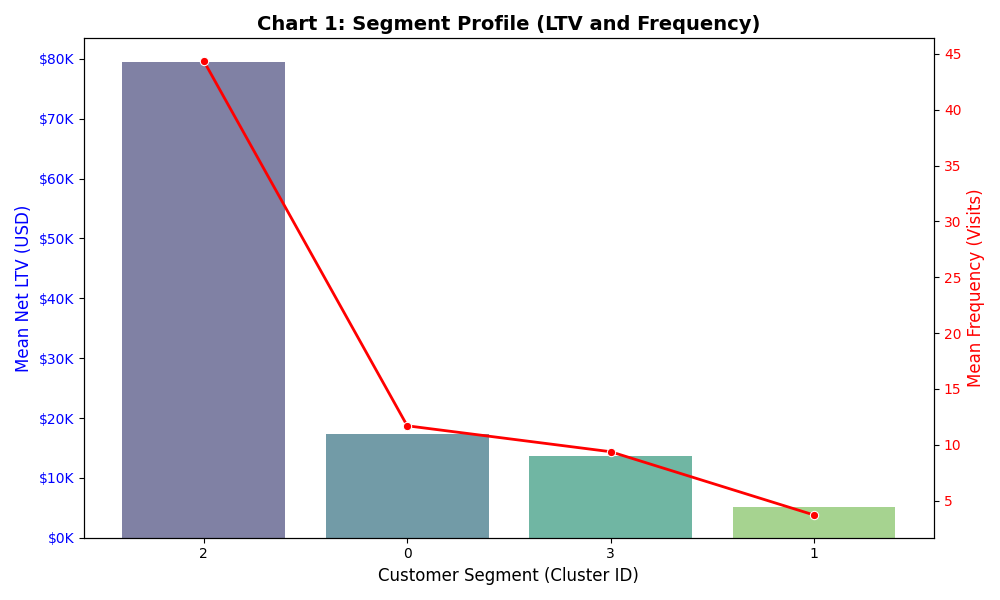


--- Displaying Chart 2: Simulated Net Profit (Gain) ---


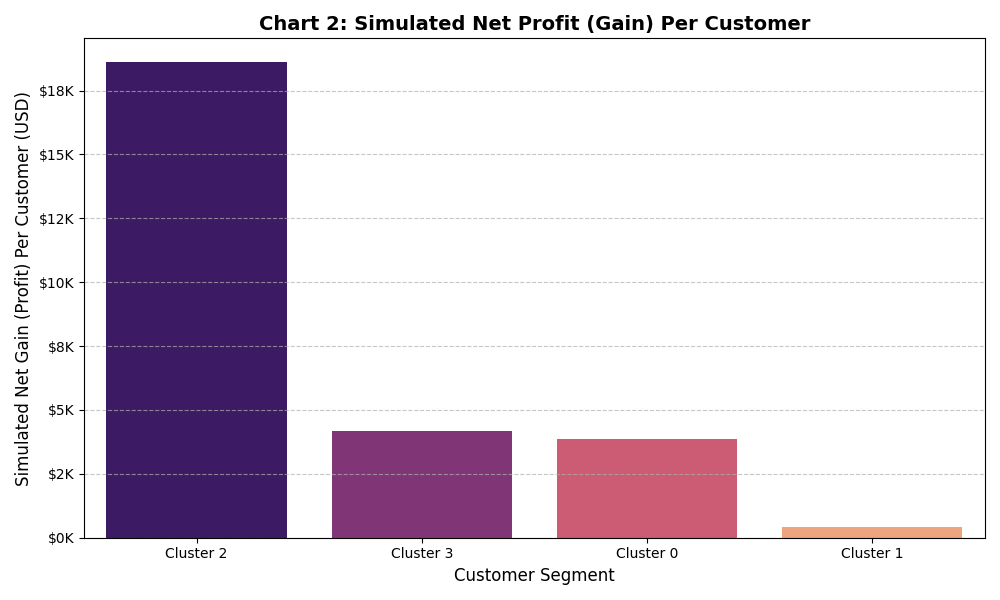

In [26]:
from IPython.display import Image, display

# --- 1. Display Chart 1: Segmentation Profile ---
print("--- Displaying Chart 1: Segmentation Profile (LTV vs. Frequency) ---")
display(Image(filename='segmentation_profile_chart.png'))

# --- 2. Display Chart 2: ROI Net Gain ---
print("\n--- Displaying Chart 2: Simulated Net Profit (Gain) ---")
display(Image(filename='roi_net_gain_chart.png'))